## Submission by : Mridul Krishnan(50049451), Mansi Pandit (50127715)

In [187]:
import os
import matplotlib
from matplotlib import pyplot as plt
from tqdm import tqdm
import seaborn as sns
import math
import numpy as np

sns.set_style("darkgrid")

In [188]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets

In [189]:
torch.cuda.is_available()

True

## Loading data and verifying

In [190]:
train_dataset = datasets.SVHN(root='./data',split='train',transform=transforms.ToTensor(),download=True)

test_dataset = datasets.SVHN(root='./data',split='test',transform=transforms.ToTensor(),download=True)

Using downloaded and verified file: ./data/train_32x32.mat
Using downloaded and verified file: ./data/test_32x32.mat


In [191]:
Batch_Size = 512

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=Batch_Size,
                                          shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=Batch_Size,
                                          shuffle=False)

In [192]:
iterator = iter(test_loader)

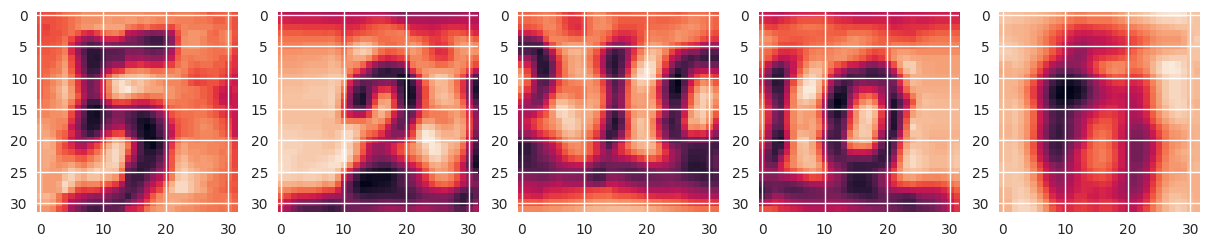

In [193]:
b = next(iterator)
fig,ax=plt.subplots(1,5)
fig.set_size_inches(15,3) 
for i in range(5):
    ax[i].imshow(b[0][i,0])
plt.show()

## Defining CNN model
We also add functions to help use visualize filters and feature maps

In [244]:
class CNN(nn.Module):
    """
    Variation of LeNet:a simple CNN model
    for handwritten digit recognition
    """
    def __init__(self):
        """Model initializer"""
        super().__init__()
        
        #Layer 1
        #(3,32,32)
        conv1 = nn.Conv2d(in_channels=3,out_channels=16, kernel_size=5, stride=1,padding=0)    #in_channels=1==grayscale image
        #(16,28,28)                     16 is number of feature maps, 28=(32-5+2*0)/1(of stride)+1,28 is the height , 28 is the width of feature map
        self.conv1 = conv1
        relu1=nn.ReLU()
        maxpool1=nn.MaxPool2d(kernel_size=2)     #used for downsampling the image
        #(16,14,14)   downsampled the image by 2 i.e 28/2=14
        
        self.layer1=nn.Sequential(
            conv1,relu1,maxpool1
        )
        
        #Visualize the weights of the first convolutional layer
        ##self.visualize_weights(conv1)
        

        #Layer 2
        #(16,14,14)
        conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=0)
        #(32,10,10)   32=no.of feature maps, 10=(14-5+2*0)/1+1 , 10=height=width
        
        relu2=nn.ReLU()
        maxpool2=nn.MaxPool2d(kernel_size=2)
        #(32,5,5)
        
        self.layer2=nn.Sequential(
            conv2,relu2,maxpool2
        )

        
        
        #fully connected classifier
        in_dim=32*5*5
        self.fc = nn.Linear(in_features=in_dim,out_features=10)
        return

    def forward(self,x):
        """forward pass"""
        cur_b_size = x.shape[0]
        out1 = self.layer1(x)
        out2 = self.layer2(out1)  #(B,32,5,5) -> (B,32*5*5)
        out2_flat = out2.view(cur_b_size,-1)
        y = self.fc(out2_flat)
        return y
        
    def visualize_weights(self, conv_layer):
        weights = conv_layer.weight.data.cpu().numpy()
        num_filters = 6
        num_channels = weights.shape[1]
        kernel_height = weights.shape[2]
        kernel_width = weights.shape[3]

        fig, axes = plt.subplots(num_filters, num_channels, figsize=(15, 10))

        for i in range(num_filters):
            for j in range(num_channels):
                ax = axes[i, j]
                ax.imshow(weights[i, j])
                ax.set_xticks([])
                ax.set_yticks([])

        plt.tight_layout()
        plt.show()

    def visualize_feature_maps(self, input_tensor):
        
        if len(input_tensor.shape) == 3:  
            input_tensor = input_tensor.unsqueeze(0)  # Add batch dimension

        # Pass the input tensor through the first convolutional layer
        feature_maps = self.layer1(input_tensor)

        # Visualize the feature maps
        num_filters = feature_maps.shape[1]
        fig, axes = plt.subplots(1, num_filters, figsize=(20, 5))

        for i in range(num_filters):
            ax = axes[i]
            feature_map = feature_maps[0, i, :, :]
            ax.imshow(feature_map.detach().cpu().numpy())
            ax.set_xticks([])
            ax.set_yticks([])

        plt.tight_layout()
        plt.show()

        plt.tight_layout()
        plt.show()
    def get_conv1(self):
        return self.conv1
        
    
def count_model_params(model):
    """ Counting the number of learnable parameters in the model"""
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return num_params


        

## Visualisation of filters and feature maps

* Visualizing the kernels(filters) can provide insights into the low-level and high-level features that the network has learned to detect. In the early layers the kernels may detect simple features like edges, corners, or color blobs, while deeper layers may capture more complex features like textures, shapes, or object parts.

* Visualizing the feature maps can help understand what features the network is detecting and where they are located in the input data. Early layers tend to capture low-level features, while deeper layers capture more abstract and complex features.

Below we have a set of visualisations before any training.

The first 6 filters of the first convolutional layer can be visualized as : 


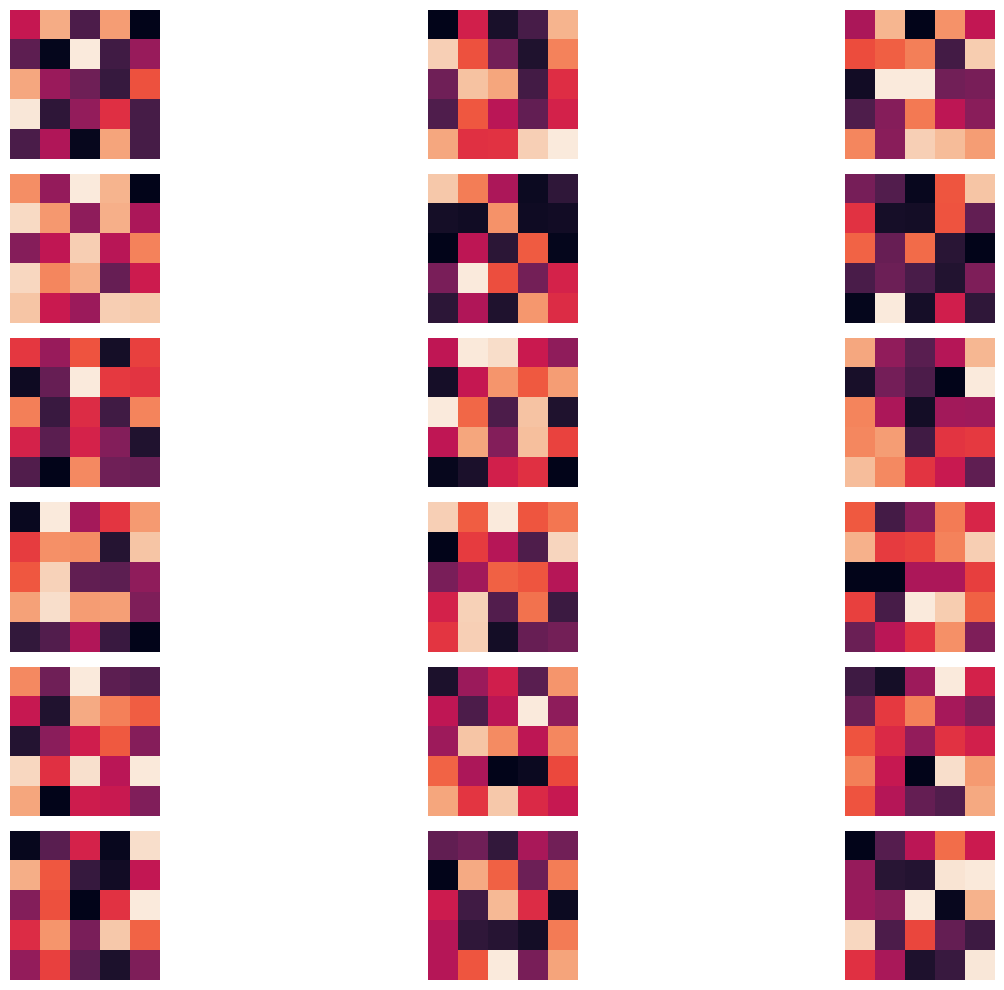

Feature maps for the images from the Layer 1 can be given as : 


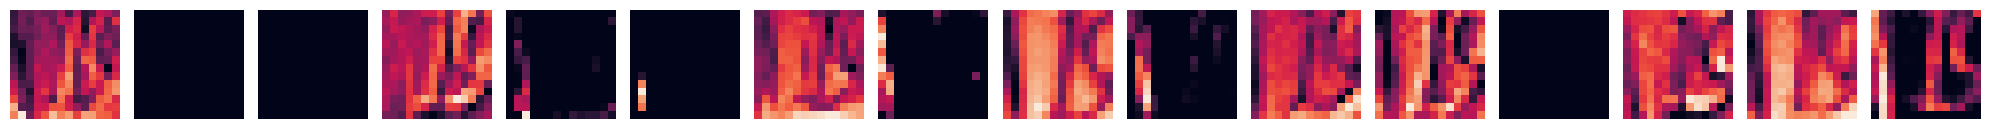

<Figure size 800x550 with 0 Axes>

In [243]:
print("The first 6 filters of the first convolutional layer can be visualized as : ")
cnn = CNN()
cnn.visualize_weights(cnn.get_conv1())
params = count_model_params(cnn)
print("Feature maps for the images from the Layer 1 can be given as : ")
sample_image, _ = train_dataset[0]
# Convert the PyTorch tensor to a PIL Image
sample_pil_image = transforms.ToPILImage()(sample_image)
cnn.visualize_feature_maps(sample_image)

In [196]:
cnn

CNN(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=800, out_features=10, bias=True)
)

In [197]:
params        #(5*5*3)*16+16+(5*5*16)*32+32+800*10+10

22058

## Training the model

In [198]:
device = torch.device("cuda" if torch.cuda.is_available else "cpu")
cnn = CNN()
cnn = cnn.to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(params=cnn.parameters(), lr=LR)


In [199]:
@torch.no_grad()
def eval_model(model):
    """Computing model accuracy"""
    correct = 0
    total = 0
    loss_list = []

    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        #forward pass only to get output
        outputs = model(images)

        loss = criterion(outputs,labels)
        loss_list.append(loss.item())

        #get predictions from the maximum value
        preds = torch.argmax(outputs,dim=1)
        correct += len(torch.where(preds==labels)[0])
        total += len(labels)

    #total correct predictions and loss
    accuracy = correct/total*100
    loss = np.mean(loss_list)
    return accuracy,loss

def save_model(model, optimizer,epoch,stats):
    """Saving model checkpoint"""
    if(not os.path.exists("models")):
        os.makedirs("models")
    savepath = f"models/checkpoint_epoch_{epoch}.pth"

    torch.save({
        'epoch':epoch,
        'model_state_dict':model.state_dict(),
        'optimizer_state_dict':optimizer.state_dict(),
        'stats':stats
    },savepath)
    return

def load_model(model,optimizer,savepath):
    """Loading pretrained checkpoint"""

    checkpoint = torch.load(savepath)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint["epoch"]
    stats = checkpoint["stats"]

    return model,optimizer,epoch,stats

In [200]:
#loading model
#savepath = os.path.join(os.getcwd(),"models","checkpoint_epoch_40.pth")
#model,optimizer,init_epoch,stats = load_model(cnn, optimizer,savepath)

### Defining Custom LR warmup and LR scheduler

In [201]:
def custom_lr_warmup(optimizer, epoch, warmup_epochs, init_lr, final_lr):
    if epoch < warmup_epochs:
        lr = init_lr + (final_lr - init_lr) * (epoch / warmup_epochs)
    else:
        lr = final_lr
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return lr

def custom_lr_scheduler(optimizer, epoch, total_epochs, init_lr, final_lr):
    if epoch < 0.5 * total_epochs:
        lr = final_lr
    elif epoch < 0.75 * total_epochs:
        lr = final_lr * 0.8
    else:
        lr = final_lr * 0.6
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return lr


### CNN model with no regularization

In [202]:
cnn = CNN()
cnn = cnn.to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(params=cnn.parameters(), lr=LR)

LR = 3e-4
EPOCHS = 20
EVAL_FREQ = 1
SAVE_FREQ = 10

stats = {
    "epoch":[],
    "train_loss":[],
    "valid_loss":[],
    "accuracy":[]
}
init_epoch=0
np.random.seed(2024) 

In [203]:

loss_hist = []

for epoch in range(init_epoch, EPOCHS):
    loss_list = []
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader))
    
    # Apply custom learning rate warmup
    warmup_epochs = 5
    init_lr = 1e-4
    final_lr = 3e-4
    if epoch<=warmup_epochs:
        current_lr = custom_lr_warmup(optimizer, epoch, warmup_epochs, init_lr, final_lr)
    
    for i, (images, labels) in progress_bar:
        images = images.to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t parameters
        optimizer.zero_grad()

        # Forward pass to get output
        outputs = cnn(images)

        # Calculate loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())

        # Getting gradients w.r.t parameters
        loss.backward()

        # Updating parameters
        optimizer.step()
        progress_bar.set_description(f"Epoch {epoch+1} Iter {i+1}: loss {loss.item():.5f}, lr {current_lr:.6f}.")

    loss_hist.append(np.mean(loss_list))
    stats["epoch"].append(epoch)
    stats["train_loss"].append(loss_hist[-1])

    # Evaluating model
    if epoch % EVAL_FREQ == 0:
        accuracy, valid_loss = eval_model(cnn)
        print(f"Accuracy at epoch {epoch+1}: {round(accuracy,2)}%")
    else:
        accuracy, valid_loss = -1, -1
    stats["accuracy"].append(accuracy)
    stats["valid_loss"].append(valid_loss)

    # Apply custom learning rate scheduler
    total_epochs = EPOCHS
    current_lr = custom_lr_scheduler(optimizer, epoch, total_epochs, init_lr, final_lr)

    # Saving checkpoint
    if epoch % SAVE_FREQ == 0:
        save_model(model=cnn, optimizer=optimizer, epoch=epoch, stats=stats)

Epoch 1 Iter 144: loss 2.22006, lr 0.000100.: 100%|███████████████████████████████████| 144/144 [00:05<00:00, 25.88it/s]


Accuracy at epoch 1: 19.59%


Epoch 2 Iter 144: loss 1.99162, lr 0.000140.: 100%|███████████████████████████████████| 144/144 [00:05<00:00, 26.53it/s]


Accuracy at epoch 2: 36.31%


Epoch 3 Iter 144: loss 1.49004, lr 0.000180.: 100%|███████████████████████████████████| 144/144 [00:05<00:00, 26.51it/s]


Accuracy at epoch 3: 65.3%


Epoch 4 Iter 144: loss 0.90364, lr 0.000220.: 100%|███████████████████████████████████| 144/144 [00:05<00:00, 26.00it/s]


Accuracy at epoch 4: 73.94%


Epoch 5 Iter 144: loss 0.79079, lr 0.000260.: 100%|███████████████████████████████████| 144/144 [00:05<00:00, 26.52it/s]


Accuracy at epoch 5: 78.53%


Epoch 6 Iter 144: loss 0.83006, lr 0.000300.: 100%|███████████████████████████████████| 144/144 [00:05<00:00, 26.54it/s]


Accuracy at epoch 6: 80.58%


Epoch 7 Iter 144: loss 1.03081, lr 0.000300.: 100%|███████████████████████████████████| 144/144 [00:05<00:00, 26.56it/s]


Accuracy at epoch 7: 82.32%


Epoch 8 Iter 144: loss 0.91130, lr 0.000300.: 100%|███████████████████████████████████| 144/144 [00:05<00:00, 26.54it/s]


Accuracy at epoch 8: 82.97%


Epoch 9 Iter 144: loss 0.44539, lr 0.000300.: 100%|███████████████████████████████████| 144/144 [00:05<00:00, 26.55it/s]


Accuracy at epoch 9: 83.27%


Epoch 10 Iter 144: loss 0.55504, lr 0.000300.: 100%|██████████████████████████████████| 144/144 [00:05<00:00, 26.55it/s]


Accuracy at epoch 10: 83.93%


Epoch 11 Iter 144: loss 0.59797, lr 0.000300.: 100%|██████████████████████████████████| 144/144 [00:05<00:00, 26.52it/s]


Accuracy at epoch 11: 83.94%


Epoch 12 Iter 144: loss 0.85646, lr 0.000240.: 100%|██████████████████████████████████| 144/144 [00:05<00:00, 26.05it/s]


Accuracy at epoch 12: 84.46%


Epoch 13 Iter 144: loss 0.38265, lr 0.000240.: 100%|██████████████████████████████████| 144/144 [00:05<00:00, 25.10it/s]


Accuracy at epoch 13: 84.33%


Epoch 14 Iter 144: loss 0.69479, lr 0.000240.: 100%|██████████████████████████████████| 144/144 [00:05<00:00, 25.98it/s]


Accuracy at epoch 14: 84.81%


Epoch 15 Iter 144: loss 0.37019, lr 0.000240.: 100%|██████████████████████████████████| 144/144 [00:05<00:00, 26.44it/s]


Accuracy at epoch 15: 85.05%


Epoch 16 Iter 144: loss 0.24773, lr 0.000240.: 100%|██████████████████████████████████| 144/144 [00:05<00:00, 26.48it/s]


Accuracy at epoch 16: 85.07%


Epoch 17 Iter 144: loss 0.25645, lr 0.000180.: 100%|██████████████████████████████████| 144/144 [00:05<00:00, 26.49it/s]


Accuracy at epoch 17: 85.23%


Epoch 18 Iter 144: loss 0.30076, lr 0.000180.: 100%|██████████████████████████████████| 144/144 [00:05<00:00, 26.14it/s]


Accuracy at epoch 18: 85.34%


Epoch 19 Iter 144: loss 0.47725, lr 0.000180.: 100%|██████████████████████████████████| 144/144 [00:05<00:00, 26.55it/s]


Accuracy at epoch 19: 85.16%


Epoch 20 Iter 144: loss 0.72118, lr 0.000180.: 100%|██████████████████████████████████| 144/144 [00:05<00:00, 26.52it/s]


Accuracy at epoch 20: 85.52%


In [204]:
accuracy, _ = eval_model(cnn)
print(f"Classification accuracy : {round(accuracy,2)}%")

Classification accuracy : 85.52%


#### Visualising train-eval loss

In [205]:
epochs = np.array(stats["epoch"])
train_loss = np.array(stats["train_loss"])

eval_loss = np.array(stats["valid_loss"])
accuracy = np.array(stats["accuracy"])
eval_idx = np.where(eval_loss != -1)[0]

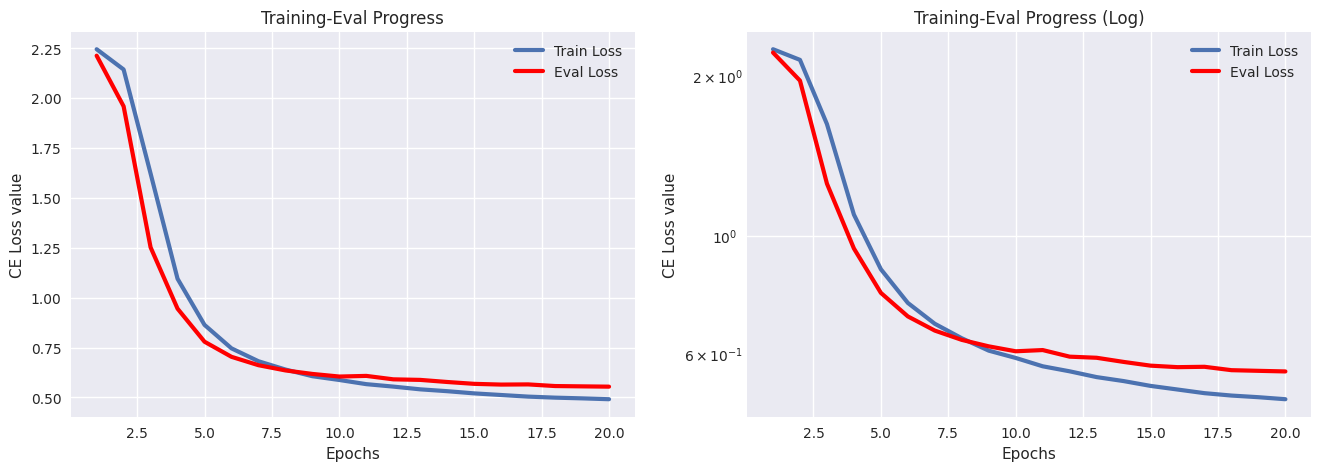

In [206]:
fig,ax=plt.subplots(1,2)
fig.set_size_inches(16,5)

for a in ax:
    a.plot(epochs+1,train_loss,label="Train Loss",linewidth=3)
    a.plot(epochs[eval_idx]+1,eval_loss[eval_idx],c="red",label="Eval Loss",linewidth=3)
    a.legend(loc="best")
    a.set_xlabel("Epochs")
    a.set_ylabel("CE Loss value")

ax[0].set_title("Training-Eval Progress")
ax[1].set_title("Training-Eval Progress (Log)")
ax[1].set_yscale("log")

plt.show()

For this mode, it appears that it has overfitted since the train loss has gone below the eval loss

In [207]:
def smooth(f,k=5):
    """smoothing a function using a low-pass filter (mean) of size k"""
    kernel = np.ones(k)/k
    f = np.concatenate([f[:int(k//2)],f,f[int(-k//2):]])     #to account for boundaries
    smooth_f = np.convolve(f,kernel,mode="same")
    smooth_f = smooth_f[k//2:-k//2] #removing boundary fixes
    return smooth_f

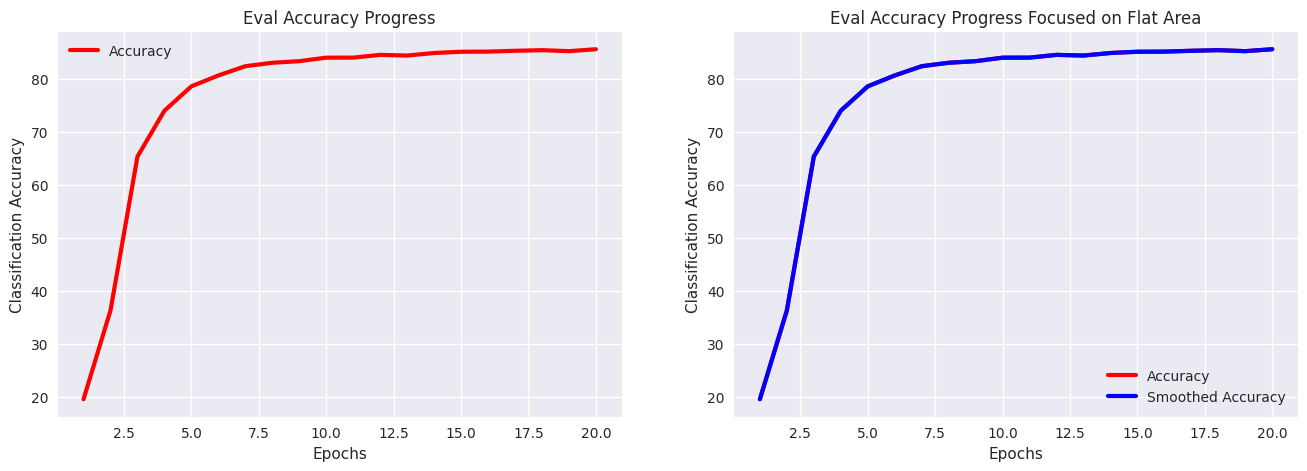

In [208]:
fig,ax = plt.subplots(1,2)
fig.set_size_inches(16,5)

ax[0].plot(epochs[eval_idx]+1,accuracy[eval_idx],c="red",label="Accuracy",linewidth=3)
ax[0].legend(loc="best")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Classification Accuracy")
ax[0].set_title("Eval Accuracy Progress")

IDX = 0
zoomed = accuracy[IDX:]
filtered = smooth(zoomed,k=1)

ax[1].plot(epochs[IDX:]+1,accuracy[IDX:],c="red",label="Accuracy",linewidth=3)
ax[1].plot(epochs[IDX:]+1,filtered,c="blue",label="Smoothed Accuracy",linewidth=3)
ax[1].legend(loc="best")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Classification Accuracy")
ax[1].set_title("Eval Accuracy Progress Focused on Flat Area")

plt.show()


#### Model with L1 regularisation

In [245]:
cnn = CNN()
cnn = cnn.to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(params=cnn.parameters(), lr=LR)

LR = 3e-4
# EPOCHS = 30
EVAL_FREQ = 1
SAVE_FREQ = 10

stats = {
    "epoch":[],
    "train_loss":[],
    "valid_loss":[],
    "accuracy":[]
}
init_epoch=0
np.random.seed(2024) 

In [246]:
import math
import torch.nn.functional as F

loss_hist = []

for epoch in range(init_epoch, EPOCHS):
    loss_list = []
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader))
    
    # Apply custom learning rate warmup
    warmup_epochs = 5
    init_lr = 1e-4
    final_lr = 3e-4
    if epoch<=warmup_epochs:
        current_lr = custom_lr_warmup(optimizer, epoch, warmup_epochs, init_lr, final_lr)
        
    for i, (images, labels) in progress_bar:
        images = images.to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t parameters
        optimizer.zero_grad()

        # Forward pass to get output
        outputs = cnn(images)

        # Calculate loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        
        # L1 regularization
        l1_lambda = 1e-4
        l1_norm = sum(p.abs().sum() for p in cnn.parameters())
        loss += l1_lambda * l1_norm
        
        # L2 regularization
        # l2_lambda = 1e-4
        # l2_norm = sum(p.pow(2.0).sum() for p in cnn.parameters())
        # loss += l2_lambda * l2_norm
        
        loss_list.append(loss.item())

        # Getting gradients w.r.t parameters
        loss.backward()

        # Updating parameters
        optimizer.step()
        progress_bar.set_description(f"Epoch {epoch+1} Iter {i+1}: loss {loss.item():.5f}, lr {current_lr:.6f}.")

    loss_hist.append(np.mean(loss_list))
    stats["epoch"].append(epoch)
    stats["train_loss"].append(loss_hist[-1])

    # Evaluating model
    if epoch % EVAL_FREQ == 0:
        accuracy, valid_loss = eval_model(cnn)
        print(f"Accuracy at epoch {epoch+1}: {round(accuracy,2)}%")
    else:
        accuracy, valid_loss = -1, -1
    stats["accuracy"].append(accuracy)
    stats["valid_loss"].append(valid_loss)

    # Apply custom learning rate scheduler
    total_epochs = EPOCHS
    current_lr = custom_lr_scheduler(optimizer, epoch, total_epochs, init_lr, final_lr)

    # Saving checkpoint
    if epoch % SAVE_FREQ == 0:
        save_model(model=cnn, optimizer=optimizer, epoch=epoch, stats=stats)

  0%|                                                                                           | 0/144 [00:00<?, ?it/s]

Epoch 1 Iter 144: loss 2.20861, lr 0.000100.: 100%|███████████████████████████████████| 144/144 [00:05<00:00, 25.80it/s]


Accuracy at epoch 1: 19.59%


Epoch 2 Iter 144: loss 2.30438, lr 0.000140.: 100%|███████████████████████████████████| 144/144 [00:05<00:00, 25.77it/s]


Accuracy at epoch 2: 21.16%


Epoch 3 Iter 144: loss 1.48981, lr 0.000180.: 100%|███████████████████████████████████| 144/144 [00:05<00:00, 25.67it/s]


Accuracy at epoch 3: 49.57%


Epoch 4 Iter 144: loss 1.40566, lr 0.000220.: 100%|███████████████████████████████████| 144/144 [00:05<00:00, 25.72it/s]


Accuracy at epoch 4: 66.57%


Epoch 5 Iter 144: loss 1.03825, lr 0.000260.: 100%|███████████████████████████████████| 144/144 [00:05<00:00, 25.80it/s]


Accuracy at epoch 5: 72.34%


Epoch 6 Iter 144: loss 1.13525, lr 0.000300.: 100%|███████████████████████████████████| 144/144 [00:05<00:00, 25.28it/s]


Accuracy at epoch 6: 77.49%


Epoch 7 Iter 144: loss 0.96920, lr 0.000300.: 100%|███████████████████████████████████| 144/144 [00:05<00:00, 25.73it/s]


Accuracy at epoch 7: 79.34%


Epoch 8 Iter 144: loss 0.40545, lr 0.000300.: 100%|███████████████████████████████████| 144/144 [00:05<00:00, 25.72it/s]


Accuracy at epoch 8: 80.13%


Epoch 9 Iter 144: loss 0.88121, lr 0.000300.: 100%|███████████████████████████████████| 144/144 [00:05<00:00, 25.72it/s]


Accuracy at epoch 9: 81.49%


Epoch 10 Iter 144: loss 0.78865, lr 0.000300.: 100%|██████████████████████████████████| 144/144 [00:05<00:00, 25.72it/s]


Accuracy at epoch 10: 82.1%


Epoch 11 Iter 144: loss 1.13505, lr 0.000300.: 100%|██████████████████████████████████| 144/144 [00:05<00:00, 25.61it/s]


Accuracy at epoch 11: 82.71%


Epoch 12 Iter 144: loss 0.53905, lr 0.000240.: 100%|██████████████████████████████████| 144/144 [00:05<00:00, 25.95it/s]


Accuracy at epoch 12: 83.15%


Epoch 13 Iter 144: loss 0.61650, lr 0.000240.: 100%|██████████████████████████████████| 144/144 [00:05<00:00, 25.99it/s]


Accuracy at epoch 13: 83.33%


Epoch 14 Iter 144: loss 0.72997, lr 0.000240.: 100%|██████████████████████████████████| 144/144 [00:05<00:00, 26.00it/s]


Accuracy at epoch 14: 83.34%


Epoch 15 Iter 144: loss 0.48695, lr 0.000240.: 100%|██████████████████████████████████| 144/144 [00:05<00:00, 26.00it/s]


Accuracy at epoch 15: 83.75%


Epoch 16 Iter 144: loss 0.81343, lr 0.000240.: 100%|██████████████████████████████████| 144/144 [00:05<00:00, 25.99it/s]


Accuracy at epoch 16: 83.93%


Epoch 17 Iter 144: loss 0.66003, lr 0.000180.: 100%|██████████████████████████████████| 144/144 [00:05<00:00, 25.63it/s]


Accuracy at epoch 17: 84.13%


Epoch 18 Iter 144: loss 0.69222, lr 0.000180.: 100%|██████████████████████████████████| 144/144 [00:05<00:00, 25.98it/s]


Accuracy at epoch 18: 84.25%


Epoch 19 Iter 144: loss 0.40752, lr 0.000180.: 100%|██████████████████████████████████| 144/144 [00:05<00:00, 26.00it/s]


Accuracy at epoch 19: 84.33%


Epoch 20 Iter 144: loss 0.58038, lr 0.000180.: 100%|██████████████████████████████████| 144/144 [00:05<00:00, 25.92it/s]


Accuracy at epoch 20: 84.53%


In [247]:
accuracy, _ = eval_model(cnn)
print(f"Classification accuracy : {round(accuracy,2)}%")

Classification accuracy : 84.53%


In [248]:
epochs = np.array(stats["epoch"])
train_loss = np.array(stats["train_loss"])

eval_loss = np.array(stats["valid_loss"])
accuracy = np.array(stats["accuracy"])
eval_idx = np.where(eval_loss != -1)[0]

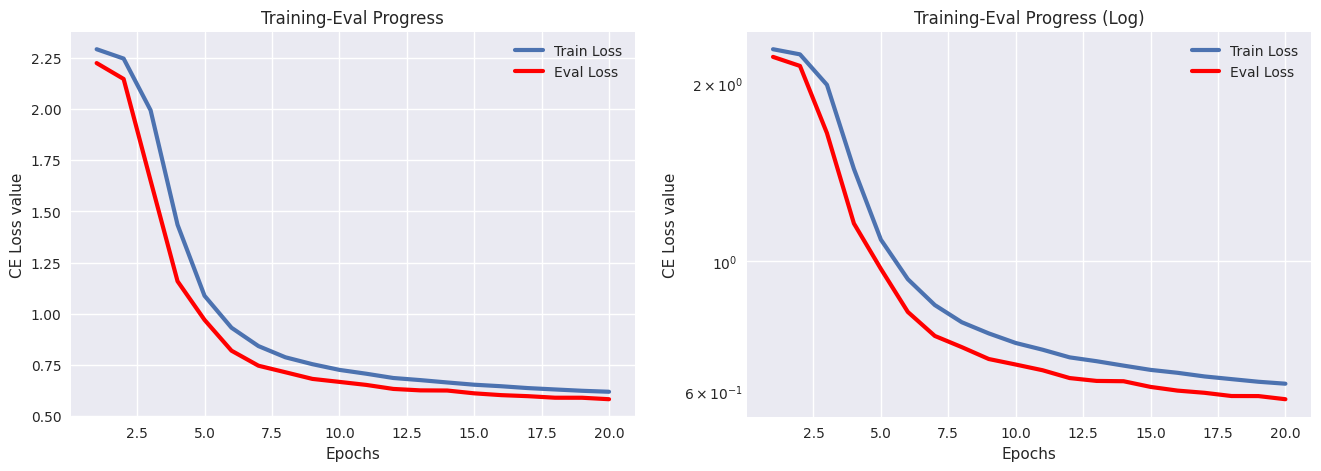

In [249]:
fig,ax=plt.subplots(1,2)
fig.set_size_inches(16,5)

for a in ax:
    a.plot(epochs+1,train_loss,label="Train Loss",linewidth=3)
    a.plot(epochs[eval_idx]+1,eval_loss[eval_idx],c="red",label="Eval Loss",linewidth=3)
    a.legend(loc="best")
    a.set_xlabel("Epochs")
    a.set_ylabel("CE Loss value")

ax[0].set_title("Training-Eval Progress")
ax[1].set_title("Training-Eval Progress (Log)")
ax[1].set_yscale("log")

plt.show()

The L1 regularised model seems to be working much better, with no sign of overfitting. Like in the previous model, we see a linear start, this is due to the warm-up LR.

In [250]:
def smooth(f,k=5):
    """smoothing a function using a low-pass filter (mean) of size k"""
    kernel = np.ones(k)/k
    f = np.concatenate([f[:int(k//2)],f,f[int(-k//2):]])     #to account for boundaries
    smooth_f = np.convolve(f,kernel,mode="same")
    smooth_f = smooth_f[k//2:-k//2] #removing boundary fixes
    return smooth_f

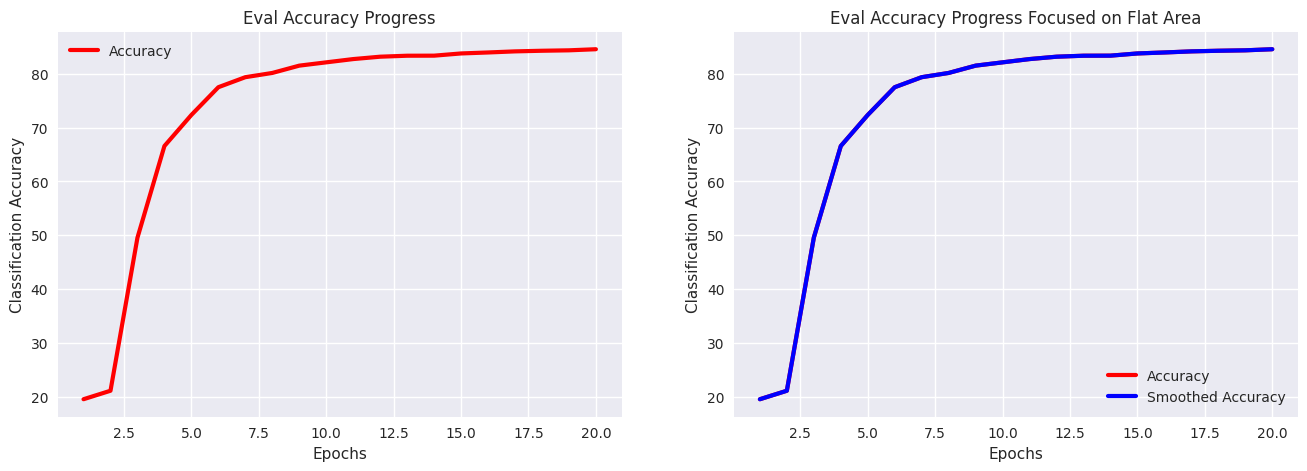

In [251]:
fig,ax = plt.subplots(1,2)
fig.set_size_inches(16,5)

ax[0].plot(epochs[eval_idx]+1,accuracy[eval_idx],c="red",label="Accuracy",linewidth=3)
ax[0].legend(loc="best")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Classification Accuracy")
ax[0].set_title("Eval Accuracy Progress")

IDX = 0
zoomed = accuracy[IDX:]
filtered = smooth(zoomed,k=1)

ax[1].plot(epochs[IDX:]+1,accuracy[IDX:],c="red",label="Accuracy",linewidth=3)
ax[1].plot(epochs[IDX:]+1,filtered,c="blue",label="Smoothed Accuracy",linewidth=3)
ax[1].legend(loc="best")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Classification Accuracy")
ax[1].set_title("Eval Accuracy Progress Focused on Flat Area")

plt.show()


### Visualising the first convulation layer weights and feature maps produced

We are doing this for our L1 model since it appears to be the best performing one.

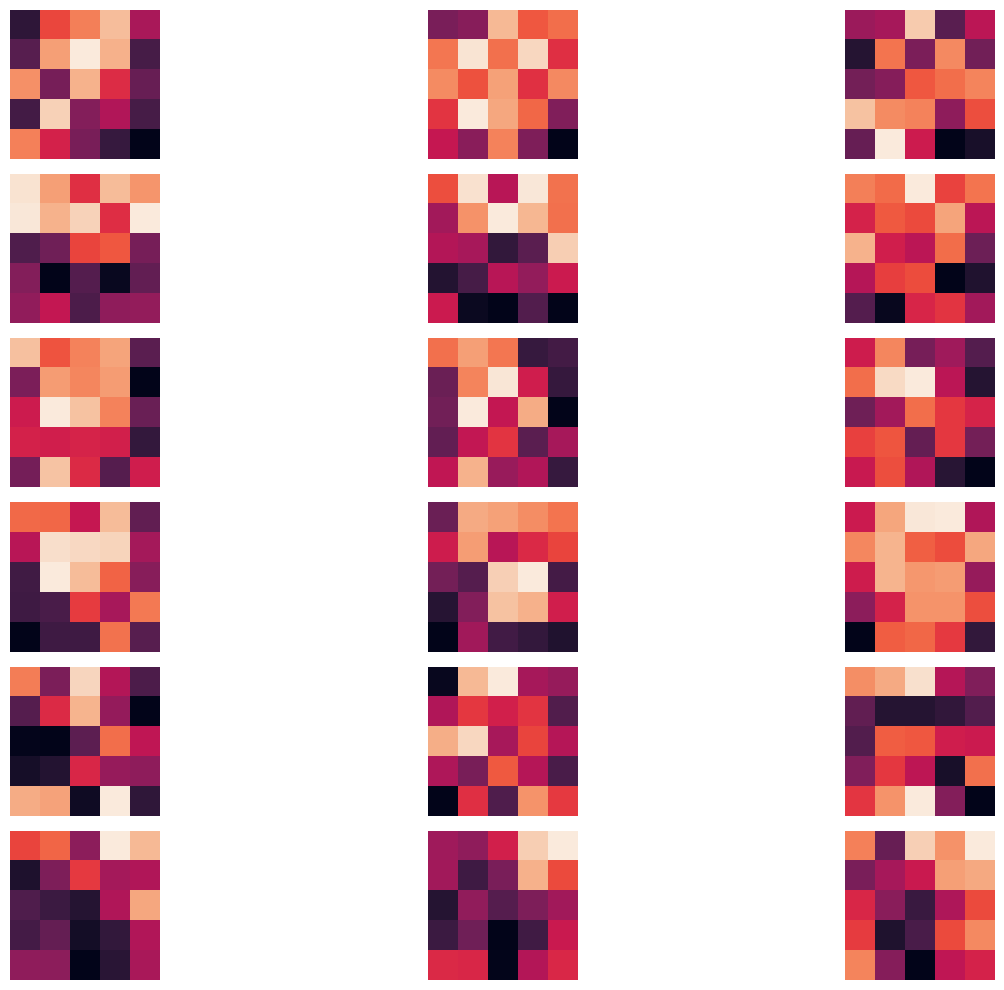

Feature maps for the images(first 5 in test set) from the Layer 1 can be given as : 


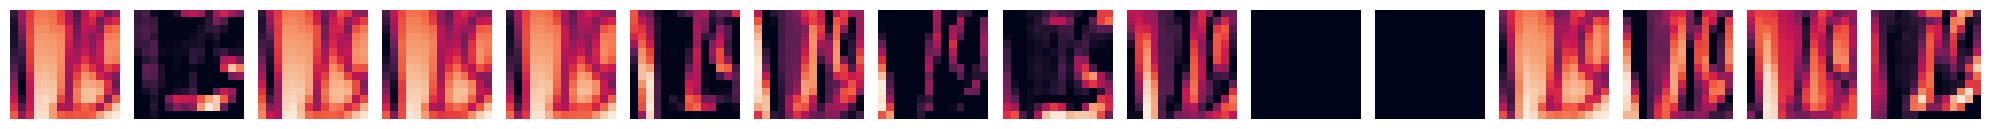

<Figure size 800x550 with 0 Axes>

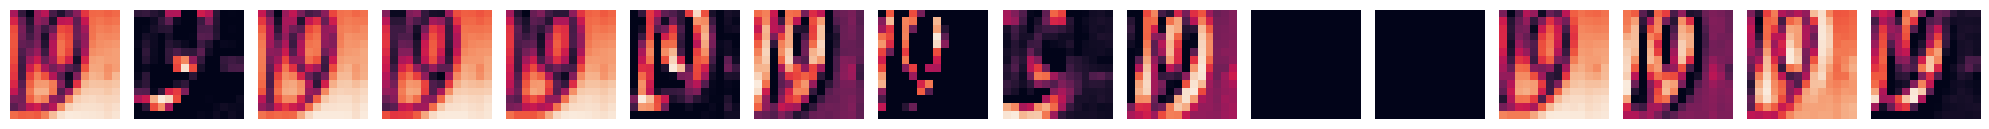

<Figure size 800x550 with 0 Axes>

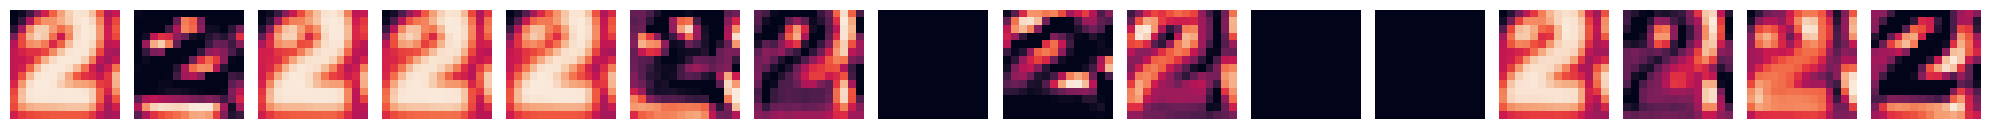

<Figure size 800x550 with 0 Axes>

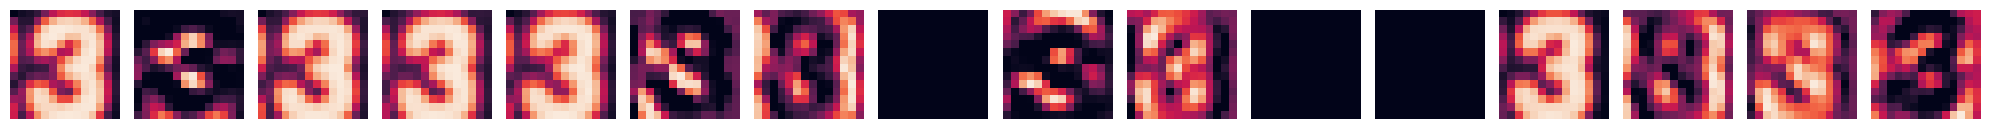

<Figure size 800x550 with 0 Axes>

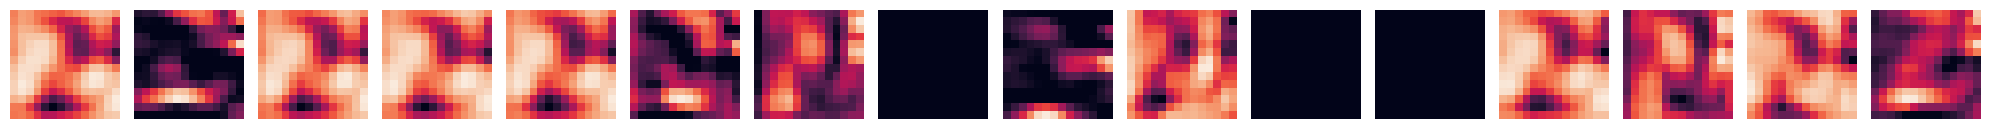

<Figure size 800x550 with 0 Axes>

In [252]:
cnn.visualize_weights(cnn.get_conv1())
params = count_model_params(cnn)
print("Feature maps for the images(first 5 in test set) from the Layer 1 can be given as : ")
for i in range(5):
    sample_image, _ = train_dataset[i]
    sample_image = sample_image.to("cpu")
    sample_image = sample_image.to(device)
    cnn.visualize_feature_maps(sample_image)

#### Model with L2 regularisation

In [217]:
cnn = CNN()
cnn = cnn.to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(params=cnn.parameters(), lr=LR)

LR = 3e-4
# EPOCHS = 30
EVAL_FREQ = 1
SAVE_FREQ = 10

stats = {
    "epoch":[],
    "train_loss":[],
    "valid_loss":[],
    "accuracy":[]
}
init_epoch=0
np.random.seed(2024) 

In [218]:
import math
import torch.nn.functional as F

loss_hist = []

for epoch in range(init_epoch, EPOCHS):
    loss_list = []
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader))
    
    # Apply custom learning rate warmup
    warmup_epochs = 5
    init_lr = 1e-4
    final_lr = 2.3e-4
    if epoch<=warmup_epochs:
        current_lr = custom_lr_warmup(optimizer, epoch, warmup_epochs, init_lr, final_lr)
        
    for i, (images, labels) in progress_bar:
        images = images.to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t parameters
        optimizer.zero_grad()

        # Forward pass to get output
        outputs = cnn(images)

        # Calculate loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        
        # L1 regularization
        # l1_lambda = 1e-4
        # l1_norm = sum(p.abs().sum() for p in cnn.parameters())
        # loss += l1_lambda * l1_norm
        
        # L2 regularization
        l2_lambda = 1e-4
        l2_norm = sum(p.pow(2.0).sum() for p in cnn.parameters())
        loss += l2_lambda * l2_norm
        
        loss_list.append(loss.item())

        # Getting gradients w.r.t parameters
        loss.backward()

        # Updating parameters
        optimizer.step()
        progress_bar.set_description(f"Epoch {epoch+1} Iter {i+1}: loss {loss.item():.5f}, lr {current_lr:.6f}.")

    loss_hist.append(np.mean(loss_list))
    stats["epoch"].append(epoch)
    stats["train_loss"].append(loss_hist[-1])

    # Evaluating model
    if epoch % EVAL_FREQ == 0:
        accuracy, valid_loss = eval_model(cnn)
        print(f"Accuracy at epoch {epoch+1}: {round(accuracy,2)}%")
    else:
        accuracy, valid_loss = -1, -1
    stats["accuracy"].append(accuracy)
    stats["valid_loss"].append(valid_loss)

    # Apply custom learning rate scheduler
    total_epochs = EPOCHS
    current_lr = custom_lr_scheduler(optimizer, epoch, total_epochs, init_lr, final_lr)

    # Saving checkpoint
    if epoch % SAVE_FREQ == 0:
        save_model(model=cnn, optimizer=optimizer, epoch=epoch, stats=stats)

Epoch 1 Iter 144: loss 2.16180, lr 0.000100.: 100%|███████████████████████████████████| 144/144 [00:05<00:00, 26.44it/s]


Accuracy at epoch 1: 19.61%


Epoch 2 Iter 144: loss 1.95536, lr 0.000126.: 100%|███████████████████████████████████| 144/144 [00:05<00:00, 26.37it/s]


Accuracy at epoch 2: 30.66%


Epoch 3 Iter 144: loss 1.56559, lr 0.000152.: 100%|███████████████████████████████████| 144/144 [00:05<00:00, 26.19it/s]


Accuracy at epoch 3: 62.39%


Epoch 4 Iter 144: loss 1.19050, lr 0.000178.: 100%|███████████████████████████████████| 144/144 [00:05<00:00, 26.29it/s]


Accuracy at epoch 4: 71.71%


Epoch 5 Iter 144: loss 0.87875, lr 0.000204.: 100%|███████████████████████████████████| 144/144 [00:05<00:00, 25.97it/s]


Accuracy at epoch 5: 76.02%


Epoch 6 Iter 144: loss 0.71572, lr 0.000230.: 100%|███████████████████████████████████| 144/144 [00:05<00:00, 26.26it/s]


Accuracy at epoch 6: 78.08%


Epoch 7 Iter 144: loss 0.77982, lr 0.000230.: 100%|███████████████████████████████████| 144/144 [00:05<00:00, 26.28it/s]


Accuracy at epoch 7: 79.59%


Epoch 8 Iter 144: loss 0.84104, lr 0.000230.: 100%|███████████████████████████████████| 144/144 [00:05<00:00, 26.29it/s]


Accuracy at epoch 8: 80.25%


Epoch 9 Iter 144: loss 0.59885, lr 0.000230.: 100%|███████████████████████████████████| 144/144 [00:05<00:00, 26.25it/s]


Accuracy at epoch 9: 82.08%


Epoch 10 Iter 144: loss 0.57889, lr 0.000230.: 100%|██████████████████████████████████| 144/144 [00:05<00:00, 26.26it/s]


Accuracy at epoch 10: 82.73%


Epoch 11 Iter 144: loss 0.52091, lr 0.000230.: 100%|██████████████████████████████████| 144/144 [00:05<00:00, 26.30it/s]


Accuracy at epoch 11: 82.81%


Epoch 12 Iter 144: loss 1.10636, lr 0.000184.: 100%|██████████████████████████████████| 144/144 [00:05<00:00, 26.25it/s]


Accuracy at epoch 12: 82.88%


Epoch 13 Iter 144: loss 0.45365, lr 0.000184.: 100%|██████████████████████████████████| 144/144 [00:05<00:00, 26.26it/s]


Accuracy at epoch 13: 83.19%


Epoch 14 Iter 144: loss 0.60587, lr 0.000184.: 100%|██████████████████████████████████| 144/144 [00:05<00:00, 26.12it/s]


Accuracy at epoch 14: 83.75%


Epoch 15 Iter 144: loss 0.56241, lr 0.000184.: 100%|██████████████████████████████████| 144/144 [00:05<00:00, 26.12it/s]


Accuracy at epoch 15: 83.47%


Epoch 16 Iter 144: loss 0.56116, lr 0.000184.: 100%|██████████████████████████████████| 144/144 [00:05<00:00, 25.90it/s]


Accuracy at epoch 16: 83.9%


Epoch 17 Iter 144: loss 0.54811, lr 0.000138.: 100%|██████████████████████████████████| 144/144 [00:05<00:00, 26.32it/s]


Accuracy at epoch 17: 83.99%


Epoch 18 Iter 144: loss 0.48412, lr 0.000138.: 100%|██████████████████████████████████| 144/144 [00:05<00:00, 26.25it/s]


Accuracy at epoch 18: 83.92%


Epoch 19 Iter 144: loss 0.35102, lr 0.000138.: 100%|██████████████████████████████████| 144/144 [00:05<00:00, 26.31it/s]


Accuracy at epoch 19: 84.13%


Epoch 20 Iter 144: loss 0.58399, lr 0.000138.: 100%|██████████████████████████████████| 144/144 [00:05<00:00, 25.87it/s]


Accuracy at epoch 20: 84.51%


In [219]:
accuracy, _ = eval_model(cnn)
print(f"Classification accuracy : {round(accuracy,2)}%")

Classification accuracy : 84.51%


In [220]:
epochs = np.array(stats["epoch"])
train_loss = np.array(stats["train_loss"])

eval_loss = np.array(stats["valid_loss"])
accuracy = np.array(stats["accuracy"])
eval_idx = np.where(eval_loss != -1)[0]

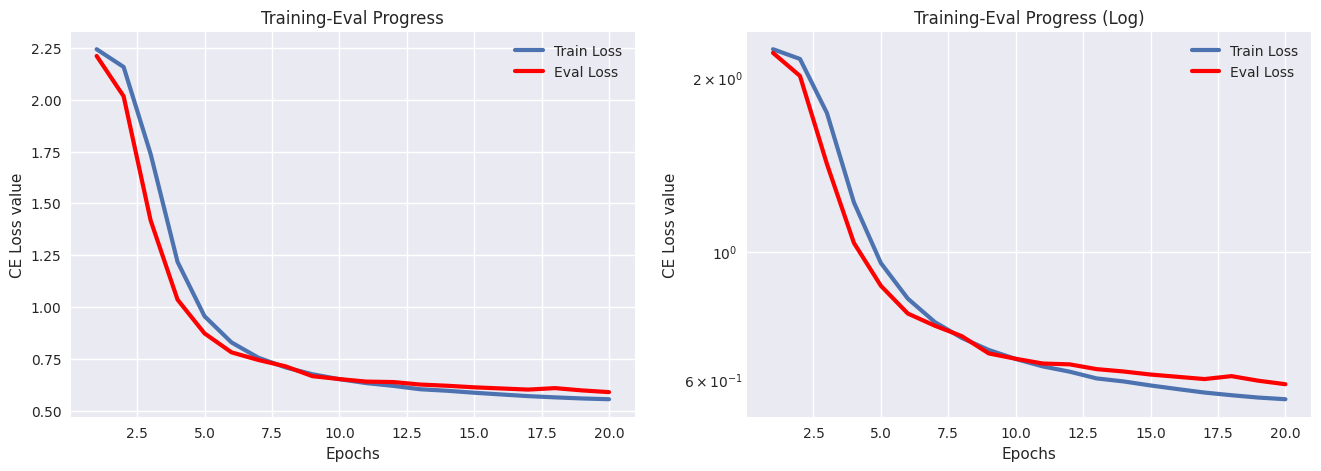

In [221]:

fig,ax=plt.subplots(1,2)
fig.set_size_inches(16,5)

for a in ax:
    a.plot(epochs+1,train_loss,label="Train Loss",linewidth=3)
    a.plot(epochs[eval_idx]+1,eval_loss[eval_idx],c="red",label="Eval Loss",linewidth=3)
    a.legend(loc="best")
    a.set_xlabel("Epochs")
    a.set_ylabel("CE Loss value")

ax[0].set_title("Training-Eval Progress")
ax[1].set_title("Training-Eval Progress (Log)")
ax[1].set_yscale("log")

plt.show()

The L2 models start to overfit around the 7th epoch. 

In [222]:
def smooth(f,k=5):
    """smoothing a function using a low-pass filter (mean) of size k"""
    kernel = np.ones(k)/k
    f = np.concatenate([f[:int(k//2)],f,f[int(-k//2):]])     #to account for boundaries
    smooth_f = np.convolve(f,kernel,mode="same")
    smooth_f = smooth_f[k//2:-k//2] #removing boundary fixes
    return smooth_f

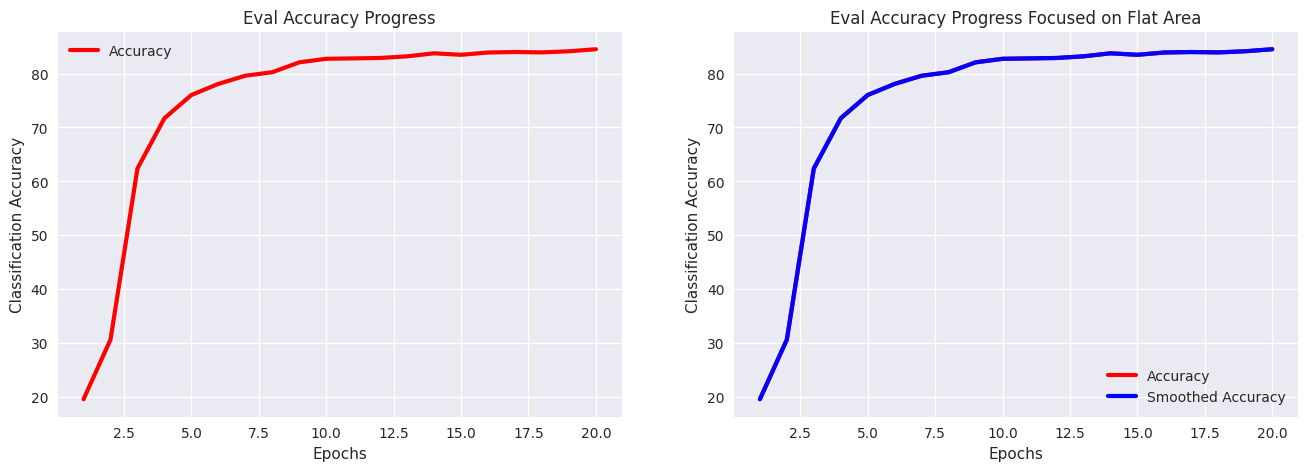

In [223]:
fig,ax = plt.subplots(1,2)
fig.set_size_inches(16,5)

ax[0].plot(epochs[eval_idx]+1,accuracy[eval_idx],c="red",label="Accuracy",linewidth=3)
ax[0].legend(loc="best")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Classification Accuracy")
ax[0].set_title("Eval Accuracy Progress")

IDX = 0
zoomed = accuracy[IDX:]
filtered = smooth(zoomed,k=1)

ax[1].plot(epochs[IDX:]+1,accuracy[IDX:],c="red",label="Accuracy",linewidth=3)
ax[1].plot(epochs[IDX:]+1,filtered,c="blue",label="Smoothed Accuracy",linewidth=3)
ax[1].legend(loc="best")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Classification Accuracy")
ax[1].set_title("Eval Accuracy Progress Focused on Flat Area")

plt.show()


#### Model with L1 and L2 regularisation

In [235]:
cnn = CNN()
cnn = cnn.to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(params=cnn.parameters(), lr=LR)

LR = 3e-4
# EPOCHS = 30
EVAL_FREQ = 1
SAVE_FREQ = 10

stats = {
    "epoch":[],
    "train_loss":[],
    "valid_loss":[],
    "accuracy":[]
}
init_epoch=0
np.random.seed(2024) 

In [236]:
import math
import torch.nn.functional as F

loss_hist = []

for epoch in range(init_epoch, EPOCHS):
    loss_list = []
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader))
    
    # Apply custom learning rate warmup
    warmup_epochs = 5
    init_lr = 1e-4
    final_lr = 3e-4
    if epoch<=warmup_epochs:
        current_lr = custom_lr_warmup(optimizer, epoch, warmup_epochs, init_lr, final_lr)
        
    for i, (images, labels) in progress_bar:
        images = images.to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t parameters
        optimizer.zero_grad()

        # Forward pass to get output
        outputs = cnn(images)

        # Calculate loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        
        # L1 regularization
        l1_lambda = 1e-4
        l1_norm = sum(p.abs().sum() for p in cnn.parameters())
        loss += l1_lambda * l1_norm
        
        # L2 regularization
        l2_lambda = 1e-4
        l2_norm = sum(p.pow(2.0).sum() for p in cnn.parameters())
        loss += l2_lambda * l2_norm
        
        loss_list.append(loss.item())

        # Getting gradients w.r.t parameters
        loss.backward()

        # Updating parameters
        optimizer.step()
        progress_bar.set_description(f"Epoch {epoch+1} Iter {i+1}: loss {loss.item():.5f}, lr {current_lr:.6f}.")

    loss_hist.append(np.mean(loss_list))
    stats["epoch"].append(epoch)
    stats["train_loss"].append(loss_hist[-1])

    # Evaluating model
    if epoch % EVAL_FREQ == 0:
        accuracy, valid_loss = eval_model(cnn)
        print(f"Accuracy at epoch {epoch+1}: {round(accuracy,2)}%")
    else:
        accuracy, valid_loss = -1, -1
    stats["accuracy"].append(accuracy)
    stats["valid_loss"].append(valid_loss)

    # Apply custom learning rate scheduler
    total_epochs = EPOCHS
    current_lr = custom_lr_scheduler(optimizer, epoch, total_epochs, init_lr, final_lr)

    # Saving checkpoint
    if epoch % SAVE_FREQ == 0:
        save_model(model=cnn, optimizer=optimizer, epoch=epoch, stats=stats)

Epoch 1 Iter 144: loss 2.23331, lr 0.000100.: 100%|███████████████████████████████████| 144/144 [00:05<00:00, 25.64it/s]


Accuracy at epoch 1: 19.59%


Epoch 2 Iter 144: loss 2.14130, lr 0.000140.: 100%|███████████████████████████████████| 144/144 [00:05<00:00, 25.68it/s]


Accuracy at epoch 2: 25.8%


Epoch 3 Iter 144: loss 1.38840, lr 0.000180.: 100%|███████████████████████████████████| 144/144 [00:05<00:00, 25.56it/s]


Accuracy at epoch 3: 57.21%


Epoch 4 Iter 144: loss 1.32480, lr 0.000220.: 100%|███████████████████████████████████| 144/144 [00:05<00:00, 25.54it/s]


Accuracy at epoch 4: 71.47%


Epoch 5 Iter 144: loss 1.03833, lr 0.000260.: 100%|███████████████████████████████████| 144/144 [00:05<00:00, 25.50it/s]


Accuracy at epoch 5: 73.74%


Epoch 6 Iter 144: loss 0.75247, lr 0.000300.: 100%|███████████████████████████████████| 144/144 [00:05<00:00, 25.39it/s]


Accuracy at epoch 6: 77.6%


Epoch 7 Iter 144: loss 0.79804, lr 0.000300.: 100%|███████████████████████████████████| 144/144 [00:05<00:00, 25.45it/s]


Accuracy at epoch 7: 80.45%


Epoch 8 Iter 144: loss 0.56436, lr 0.000300.: 100%|███████████████████████████████████| 144/144 [00:05<00:00, 25.13it/s]


Accuracy at epoch 8: 81.31%


Epoch 9 Iter 144: loss 0.81346, lr 0.000300.: 100%|███████████████████████████████████| 144/144 [00:05<00:00, 25.54it/s]


Accuracy at epoch 9: 81.32%


Epoch 10 Iter 144: loss 0.95261, lr 0.000300.: 100%|██████████████████████████████████| 144/144 [00:05<00:00, 25.43it/s]


Accuracy at epoch 10: 82.66%


Epoch 11 Iter 144: loss 0.75207, lr 0.000300.: 100%|██████████████████████████████████| 144/144 [00:05<00:00, 25.51it/s]


Accuracy at epoch 11: 82.99%


Epoch 12 Iter 144: loss 0.62575, lr 0.000240.: 100%|██████████████████████████████████| 144/144 [00:05<00:00, 25.45it/s]


Accuracy at epoch 12: 83.06%


Epoch 13 Iter 144: loss 0.45653, lr 0.000240.: 100%|██████████████████████████████████| 144/144 [00:05<00:00, 25.54it/s]


Accuracy at epoch 13: 83.27%


Epoch 14 Iter 144: loss 0.47591, lr 0.000240.: 100%|██████████████████████████████████| 144/144 [00:05<00:00, 25.56it/s]


Accuracy at epoch 14: 83.65%


Epoch 15 Iter 144: loss 0.80027, lr 0.000240.: 100%|██████████████████████████████████| 144/144 [00:05<00:00, 25.50it/s]


Accuracy at epoch 15: 84.16%


Epoch 16 Iter 144: loss 0.74407, lr 0.000240.: 100%|██████████████████████████████████| 144/144 [00:05<00:00, 25.49it/s]


Accuracy at epoch 16: 84.03%


Epoch 17 Iter 144: loss 0.49236, lr 0.000180.: 100%|██████████████████████████████████| 144/144 [00:05<00:00, 25.59it/s]


Accuracy at epoch 17: 84.57%


Epoch 18 Iter 144: loss 0.65156, lr 0.000180.: 100%|██████████████████████████████████| 144/144 [00:05<00:00, 25.60it/s]


Accuracy at epoch 18: 84.46%


Epoch 19 Iter 144: loss 0.59153, lr 0.000180.: 100%|██████████████████████████████████| 144/144 [00:05<00:00, 25.33it/s]


Accuracy at epoch 19: 84.52%


Epoch 20 Iter 144: loss 0.46438, lr 0.000180.: 100%|██████████████████████████████████| 144/144 [00:05<00:00, 25.55it/s]


Accuracy at epoch 20: 84.68%


In [237]:
accuracy, _ = eval_model(cnn)
print(f"Classification accuracy : {round(accuracy,2)}%")

Classification accuracy : 84.68%


In [238]:
epochs = np.array(stats["epoch"])
train_loss = np.array(stats["train_loss"])

eval_loss = np.array(stats["valid_loss"])
accuracy = np.array(stats["accuracy"])
eval_idx = np.where(eval_loss != -1)[0]

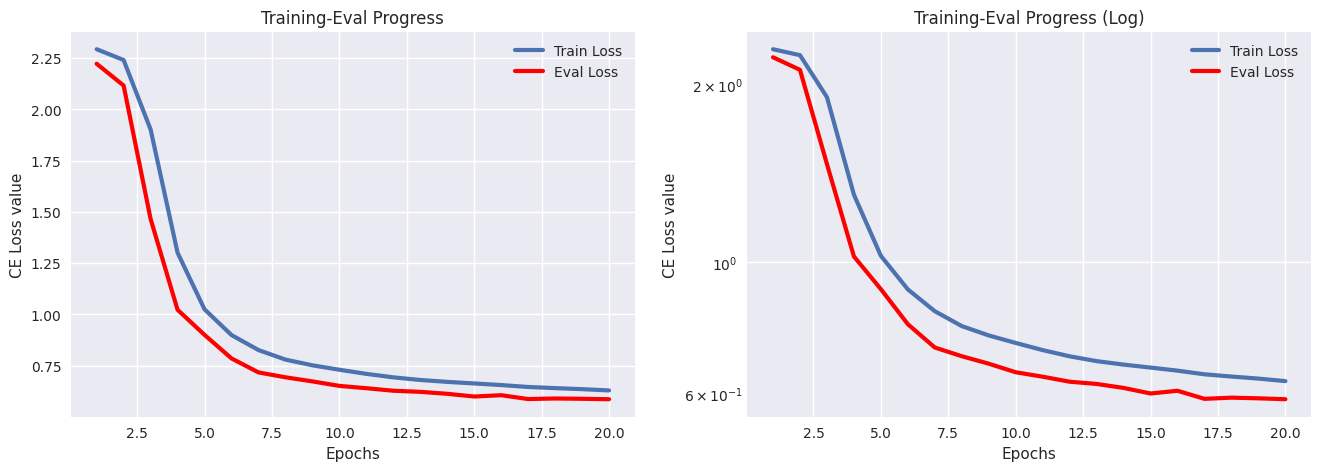

In [239]:
fig,ax=plt.subplots(1,2)
fig.set_size_inches(16,5)

for a in ax:
    a.plot(epochs+1,train_loss,label="Train Loss",linewidth=3)
    a.plot(epochs[eval_idx]+1,eval_loss[eval_idx],c="red",label="Eval Loss",linewidth=3)
    a.legend(loc="best")
    a.set_xlabel("Epochs")
    a.set_ylabel("CE Loss value")

ax[0].set_title("Training-Eval Progress")
ax[1].set_title("Training-Eval Progress (Log)")
ax[1].set_yscale("log")

plt.show()

The L1+L2 model seems to work pretty good as well, better than L1 perhaps, as the train curve doesn't seem to almost overlap with the loss curve.

In [240]:
def smooth(f,k=5):
    """smoothing a function using a low-pass filter (mean) of size k"""
    kernel = np.ones(k)/k
    f = np.concatenate([f[:int(k//2)],f,f[int(-k//2):]])     #to account for boundaries
    smooth_f = np.convolve(f,kernel,mode="same")
    smooth_f = smooth_f[k//2:-k//2] #removing boundary fixes
    return smooth_f

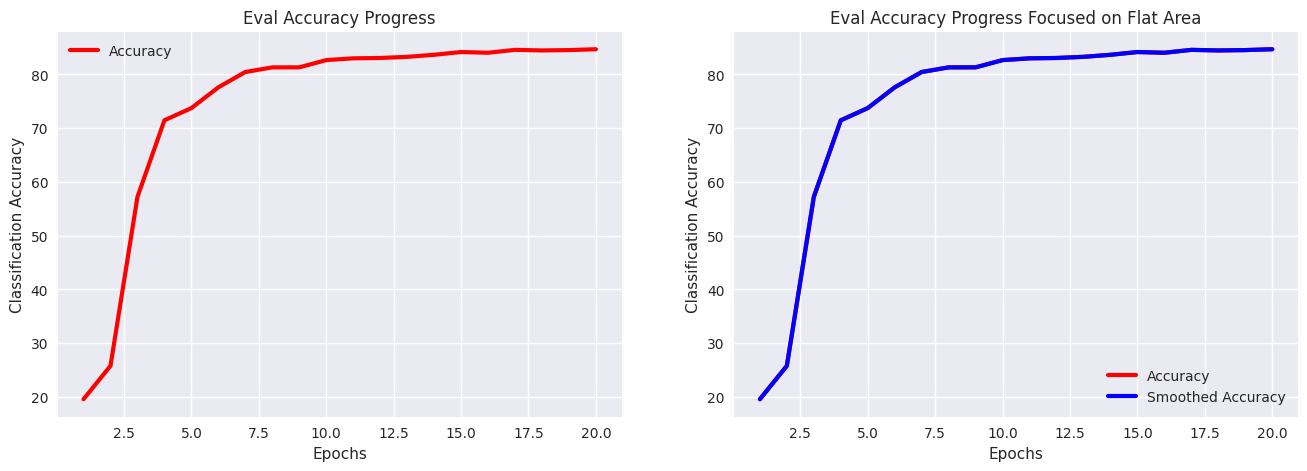

In [241]:
fig,ax = plt.subplots(1,2)
fig.set_size_inches(16,5)

ax[0].plot(epochs[eval_idx]+1,accuracy[eval_idx],c="red",label="Accuracy",linewidth=3)
ax[0].legend(loc="best")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Classification Accuracy")
ax[0].set_title("Eval Accuracy Progress")

IDX = 0
zoomed = accuracy[IDX:]
filtered = smooth(zoomed,k=1)

ax[1].plot(epochs[IDX:]+1,accuracy[IDX:],c="red",label="Accuracy",linewidth=3)
ax[1].plot(epochs[IDX:]+1,filtered,c="blue",label="Smoothed Accuracy",linewidth=3)
ax[1].legend(loc="best")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Classification Accuracy")
ax[1].set_title("Eval Accuracy Progress Focused on Flat Area")

plt.show()
